<br>

# GloVe Embeddings to filter SMS Spam
***Reynaldo Vazquez***  
***April, 2018***

[GitHub Pages](https://reyvaz.github.io/GloVe-SMS)

## Uses GloVe embeddings to filter out spam in text messages


It is important to avoid misclassification of legitimate text messages as spam, i.e., it is preferable to let some spam to be misclassified as legitimate than the other way around. However, the ultimate goal of the "ham vs spam" problem is to be able to eliminate as much spam as possible, while avoiding misclassification of legitimate messages. Because text messages are mostly not spam, it is typical for a model to achieve high accuracy, even when the model is missclassifying spam messages. **In this analysis, a specification that uses GloVe embeddings on a Support Vector Classifier is able to tag every legitimate message correctly, while filtering out over 99% of spam messages**. 

The dataset for this analysis  was downloaded from [Kaggle](https://www.kaggle.com/uciml/sms-spam-collection-dataset), and can also be found at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). Acknowledgements to Tiago A. Almeida and José María Gómez Hidalgo, creators  of the original dataset. More information can be found [here](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/).

The GloVe encodings used are the 50 dimensional, 400K vocabulary from the the `glove.6B.zip`. More information and download link can be found [here](https://nlp.stanford.edu/projects/glove).

- `glove_sms_utils.py` can be found [here](https://raw.githubusercontent.com/reyvaz/GloVe-SMS/master/glove_sms_utils.py)
- `cm_heat_plots.py` can be found [here](https://raw.githubusercontent.com/reyvaz/GloVe-SMS/master/cm_heat_plots.py)
- `spelling_v2.py` can be found [here](https://raw.githubusercontent.com/reyvaz/GloVe-SMS/master/spelling_v2.py)


<img src="media/sms_png.png" style="width:200px;padding:25px" align="left">

#### Model metrics using GloVe features  on a Support Vector Classifier
```
               precision   recall   f1-score   
   not spam       1.00      1.00      1.00       
       spam       1.00      0.99      0.99       
        avg       1.00      1.00      1.00      

AUC  = 0.993
Train Accuracy = 0.998
Test Accuracy  = 0.998
```

### Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack
from cm_heat_plots import *
from my_nlp_paths import *
from glove_sms_utils import *
from spelling_v2 import *
import time
np.random.seed(1)
%matplotlib inline

### Dataset

In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1', header=0, 
                 names = ['target', 'text'], usecols = [0, 1])
pd.set_option('display.max_colwidth', 120)
print('Dataset shape: ', df.shape)

Dataset shape:  (5572, 2)


### Transform target variable to dummy

In [3]:
df['target'] = np.where(df['target']=='spam',1,0)

In [4]:
classes_dict = {0:'not spam', 1:'spam'}

In [5]:
classes = list(classes_dict.values())
print(classes)

['not spam', 'spam']


### GloVe Vector Representations.

In [6]:
word_to_index, _, word_to_glove = read_glove_vecs(glove_path)

### Spelling corrector and word mapping

In [7]:
word = "articifial"
corrected_word = correction(word)
print("'" + word + "'" + " has been replaced with " + "'" + corrected_word + "'")
print("the index of " + "'" + corrected_word + "'" +  " is " + str(word_to_index[corrected_word]))

'articifial' has been replaced with 'artificial'
the index of 'artificial' is 60401


In [8]:
# loads, or fixes word misspellings of df['text'] to run over the Glove encoder
if os.path.isfile("data/sms_corrected.csv"):
    sms_corrected = pd.read_csv("data/sms_corrected.csv", sep=',', skip_blank_lines = False)
    keep_index = np.array(sms_corrected.iloc[:,0].notnull())
else:
    sms_corrected = correct_list(df['text'])
    sms_corrected =  pd.DataFrame(sms_corrected)
    keep_index = np.array(sms_corrected.iloc[:,0] != '')
    # time consuming, save once created
    sms_corrected.to_csv("data/sms_corrected.csv", sep=',', index = False)

In [9]:
print(sum(keep_index == False), "rows not able to be GloVe encoded will be removed")

2 rows not able to be GloVe encoded will be removed


In [10]:
data = df[keep_index].reset_index()
sms_corrected = sms_corrected[keep_index]

### Encode messages with their Glove embeddings means

In [11]:
def sen2average(sentence, word_to_glove = word_to_glove):
    """
    Encodes the meaning of a sentence by averaging representation vectors.
    
    Args:
        sentence: a sentence (string)
        word_to_glove: dictionary mapping words into their n-dimensional vector representation
    Returns:
        average: vector with the meaning of the sentence enconded
    """
    words = sentence.split()
    average = sum([word_to_glove[w] for w in words])/len(words)
    return average

In [12]:
sms_corrected = np.array(sms_corrected.iloc[:,0])
sms_glove_means = np.array([sen2average(sentence) for sentence in sms_corrected])
sms_glove_means.shape

(5570, 50)

In [13]:
X_glove_means = pd.DataFrame(sms_glove_means)

In [14]:
data = pd.concat([data, X_glove_means], axis = 1)

In [15]:
Y = data['target']
X = data.copy()
X.drop(['index', 'target'], axis=1, inplace = True)

In [16]:
print('Fraction spam in full dataset:', Y.mean())

Fraction spam in full dataset: 0.1341113105924596


### Split dataset into training and testing

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size=1000)
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('Fraction spam in train dataset:', Y_train.mean())

X_train shape: (4570, 51)
Y_train shape: (4570,)
Fraction spam in train dataset: 0.13216630196936544


Separate the text from the vectors in the features sets, they need to be processed differently

In [18]:
X_train_text = X_train['text']
X_train_vec  = X_train.iloc[:, 1:]
X_test_text  = X_test['text']
X_test_vec   = X_test.iloc[:, 1:]

### Training and reporting function
Will train and return the trained specified model. Will print model preformance metrics.

In [19]:
def run_model(X_train, Y_train, X_test, Y_test, model, classes_dict = classes_dict):
    """
    Trains the specified model, calculates predictions, and returns and prints the
    classification report and accuracy metric.
    """
    print("Model:", str(model).split("(")[0], "\n")
    start_time = time.time()
    trained_model = model.fit(X_train, Y_train)
    elapsed_time = time.time() - start_time
    predicted_Y_test = trained_model.predict(X_test)
    predicted_Y_train = trained_model.predict(X_train)
    print("Classification report on test set \n")
    pred_activity = [classes_dict[label] for label in predicted_Y_test]
    actual_activity = [classes_dict[label] for label in Y_test]
    report = classification_report(actual_activity, pred_activity)
    train_acc = accuracy_score(Y_train, predicted_Y_train)
    test_acc = accuracy_score(Y_test, predicted_Y_test)
    auc  = roc_auc_score(Y_test, predicted_Y_test)
    print(report)
    print("AUC  =", str(format(auc, '.3f')))
    print("Train Accuracy =", str(format(train_acc, '.3f')))
    print("Test Accuracy  =", str(format(test_acc, '.3f')))
    print("Training time:", int(elapsed_time), "seconds")
    return trained_model, report

### Benchmarks
Will train: 
- **Multinomial Naive Bayes** with all the words in the training set as features, and no extra features. This was one of the 2 best performing specifications in a previous analysis
- **Linear Support Vector** with the same features just described. For comparison, this model will be enhanced with the Glove features.

In [20]:
vect1 = CountVectorizer().fit(X_train_text)
X_train1 = vect1.transform(X_train_text)
X_test1 = vect1.transform(X_test_text)

In [21]:
mnb = MultinomialNB(alpha=0.1)
mnb_trained, _ = run_model(X_train1, Y_train, X_test1, Y_test, mnb)

Model: MultinomialNB 

Classification report on test set 

             precision    recall  f1-score   support

   not spam       0.99      1.00      0.99       857
       spam       0.97      0.96      0.96       143

avg / total       0.99      0.99      0.99      1000

AUC  = 0.977
Train Accuracy = 0.996
Test Accuracy  = 0.990
Training time: 0 seconds


In [22]:
from sklearn.svm import LinearSVC
lsvc_1 = LinearSVC(C = 100, penalty = 'l1', tol = 1e-6, dual = False, random_state = 0)
lsvc_1_trained, _ = run_model(X_train1, Y_train, X_test1, Y_test, lsvc_1)

Model: LinearSVC 

Classification report on test set 

             precision    recall  f1-score   support

   not spam       0.98      1.00      0.99       857
       spam       0.98      0.88      0.93       143

avg / total       0.98      0.98      0.98      1000

AUC  = 0.939
Train Accuracy = 1.000
Test Accuracy  = 0.980
Training time: 0 seconds


### Adding New Features

In [23]:
# indexes of ham and spam in training set for additional feature search
ham  = [i for i, x in enumerate(Y_train == 0) if x]
spam = [i for i, x in enumerate(Y_train == 1) if x]

#### Message Lenghts (Number of Characters) between Ham and Spam

In [24]:
doc_lengths_train = np.array([len(d) for d in X_train_text])
mean_len_ham = np.mean(doc_lengths_train[ham])
mean_len_spam = np.mean(doc_lengths_train[spam])
print('Average Length', '\nNot Spam:  ', mean_len_ham, 'chars',
      '\nSpam: ', mean_len_spam, 'chars')

Average Length 
Not Spam:   70.74457892082702 chars 
Spam:  139.1937086092715 chars


#### Digit Counts between Ham and Spam

In [25]:
digits_train = X_train_text.str.findall('\d')
dig_counts_train = np.array([len(d) for d in digits_train])
mean_dig_ham = np.mean(dig_counts_train[ham])
mean_dig_spam = np.mean(dig_counts_train[spam])
print('Average digit counts', '\nNot Spam:  ', mean_dig_ham, 'digits',
      '\nSpam: ', mean_dig_spam, 'digits')

Average digit counts 
Not Spam:   0.3015632879475542 digits 
Spam:  15.46523178807947 digits


#### Non-Alphanumeric Characters between Ham and Spam

In [26]:
non_alnum_train = X_train_text.str.findall('\W')
non_alnum_counts_train = np.array([len(d) for d in non_alnum_train])
mean_nw_ham = np.mean(non_alnum_counts_train[ham])
mean_nw_spam = np.mean(non_alnum_counts_train[spam])
print('Average non-alnum char counts', '\nNot Spam:  ', mean_nw_ham, 'non-alnum chars',
      '\nSpam: ', mean_nw_spam, 'non-alnum chars')

Average non-alnum char counts 
Not Spam:   17.240544629349472 non-alnum chars 
Spam:  29.13907284768212 non-alnum chars


The three features, length, digit count, non-alnum count will be added to the model

In [27]:
def spec2_features(X_orig):
    """
    Calculates the new features for a new (i.e. test) set
    """
    doc_lengths = np.array([len(d) for d in X_orig])

    digits = X_orig.str.findall('\d')
    dig_counts = np.array([len(d) for d in digits])

    non_alnum = X_orig.str.findall('\W')
    non_alnum_counts = np.array([len(d) for d in non_alnum])
    return doc_lengths, dig_counts, non_alnum_counts

doc_lengths_test, dig_counts_test, non_alnum_counts_test = spec2_features(X_test_text)

In [28]:
# Adds additional features to the sparse matrix feature sets
def add_features(X_sparse, new_features):
    """
    Returns sparse feature matrix with new feature(s) added.
    new_features can be one new feature or a list of features.
    """
    return hstack([X_sparse, csr_matrix(new_features).T], 'csr')

def transform_X(X, new_features, vect):
    X_sparse  = vect.transform(X)
    X_transformed = add_features(X_sparse, new_features)
    return X_transformed

### New Features Specification: 

* 2 to 5 character ngrams as features
* Ignore terms that have a document frequency strictly lower than 3  
* Add text lenght, digit count, and non-alphanumeric character count as features
* Add the GloVe average meanings vectors

In [29]:
vect2 = CountVectorizer(min_df=3, ngram_range=(2,5), analyzer='char_wb').fit(X_train_text)
# Convert vectors of vectors into lists of vectors to add to sparse matrix
X_train_vec_list = list(np.array(X_train_vec).T)
X_test_vec_list = list(np.array(X_test_vec).T)
new_features_train = [doc_lengths_train, dig_counts_train, non_alnum_counts_train] +  X_train_vec_list
X_train2 = transform_X(X_train_text, new_features_train, vect2)
new_features_test = [doc_lengths_test, dig_counts_test, non_alnum_counts_test] + X_test_vec_list
X_test2 = transform_X(X_test_text, new_features_test, vect2)

In [30]:
lsvc_2 = LinearSVC(C = 100, penalty = 'l1', tol = 1e-6, dual = False, random_state = 0)
lsvc_2_trained, _ = run_model(X_train2, Y_train, X_test2, Y_test, lsvc_2)

Model: LinearSVC 

Classification report on test set 

             precision    recall  f1-score   support

   not spam       1.00      1.00      1.00       857
       spam       0.99      0.99      0.99       143

avg / total       1.00      1.00      1.00      1000

AUC  = 0.992
Train Accuracy = 1.000
Test Accuracy  = 0.997
Training time: 2 seconds


In [31]:
svc = SVC(C = 100, random_state = 0)
svc_trained, _ = run_model(X_train2, Y_train, X_test2, Y_test, svc)

Model: SVC 

Classification report on test set 

             precision    recall  f1-score   support

   not spam       1.00      1.00      1.00       857
       spam       1.00      0.99      0.99       143

avg / total       1.00      1.00      1.00      1000

AUC  = 0.993
Train Accuracy = 0.998
Test Accuracy  = 0.998
Training time: 2 seconds


### Features with large (absolute) coefficients

In [32]:
coefficients = lsvc_2_trained.coef_[0]
# need to concatenate the added features names to the .get_feature_names() output
orig_names = np.array(vect2.get_feature_names())
glove_names = ['glov'+ str(g) for g in range(X_train_vec.shape[1])]
added_names = ["doc_lengths", "dig_counts", "non_alnums"] + glove_names
added_names = np.array(added_names)
feature_names = np.concatenate((orig_names, added_names))

In [33]:
features = infl_features_non_tr(coefficients, feature_names, num_features = 12)

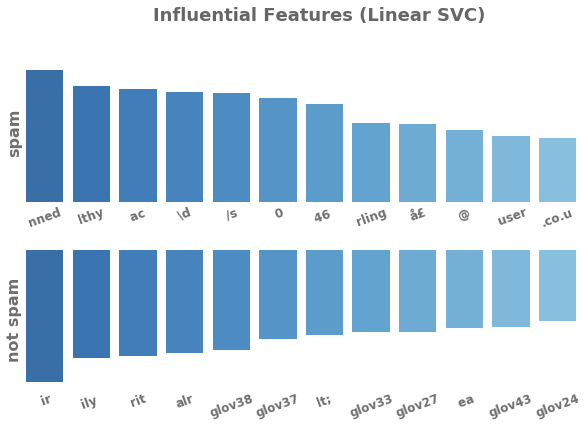

In [34]:
plot_features(features, 'Linear SVC', classes = classes, label_rotation = 20, cmap = plt.cm.Blues)

### Prediction Time and Confusion Matrix

In [35]:
mnb_predictions = predict_and_time(mnb_trained, X_test1)

Time to calculate 1000 predictions with MultinomialNB model: 0.0014 seconds


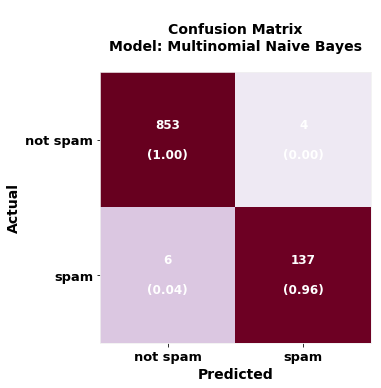

In [36]:
cm_mnb = confusion_matrix(Y_test, mnb_predictions)
heated_confusion_matrix(cm = cm_mnb, labels = classes, cmap = plt.cm.PuRd, 
                        contrast = 2, model_name = "Multinomial Naive Bayes", 
                        p_size = 5.5)

In [37]:
svc_predictions = predict_and_time(svc_trained, X_test2)

Time to calculate 1000 predictions with SVC model: 0.7633 seconds


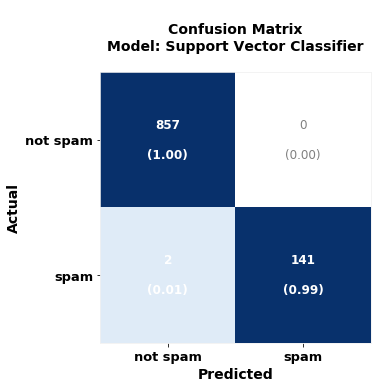

In [38]:
cm_svc = confusion_matrix(Y_test, svc_predictions)
heated_confusion_matrix(cm = cm_svc, labels = classes, cmap = plt.cm.Blues, 
                        contrast = 2, model_name = "Support Vector Classifier", 
                        p_size = 5.5, save_fig = False)

#### See the mislabeled messages (spam mislabeled as not spam)

In [39]:
print('\n\n'.join(X_test_text[(Y_test != svc_predictions)]))

You have an important customer service announcement from PREMIER.

Latest News! Police station toilet stolen, cops have nothing to go on!


### Conclusion

The Support Vector Classifier on ngrams, the three quantitative features, and the GloVe average meanings encodings performs better than the benchmark by most metrics, and at least as well by all metrics (excluding training and prediction time). Although the improvements seem small, it achieves the goal of not mistagging legitimate messages, while nearly eliminating all spam. 

### Reference

**Almeida, T.A., Gómez Hidalgo, J.M., Yamakami, A.** Contributions to the Study of SMS Spam Filtering: New Collection and Results.  Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011. [http://www.dt.fee.unicamp.br/~tiago//smsspamcollection](http://www.dt.fee.unicamp.br/~tiago//smsspamcollection).